# Installing dependencies

In [1]:
!nvidia-smi

Thu Feb 22 08:49:17 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    16W /  70W |      2MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nvidia-smi --query-compute-apps=pid --format=csv,noheader | awk '{print $1}' | xargs -r kill -9

In [3]:
!pip install diffusers
!pip install torch torchvision torchaudio
!pip install diffusers
!pip install transformers scipy ftfy accelerate

# Setting up the pipeline

In [2]:
from compel import Compel, ReturnedEmbeddingsType
from diffusers import DiffusionPipeline
from diffusers.utils import make_image_grid
import torch

pipeline = DiffusionPipeline.from_pretrained(
  "stabilityai/stable-diffusion-xl-base-1.0",
  variant="fp16",
  use_safetensors=True,
  torch_dtype=torch.float16
).to("cuda")

compel = Compel(
  tokenizer=[pipeline.tokenizer, pipeline.tokenizer_2] ,
  text_encoder=[pipeline.text_encoder, pipeline.text_encoder_2],
  returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
  requires_pooled=[False, True]
)

/opt/conda/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/conda/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
pipeline.enable_freeu(s1=0.6, s2=0.4, b1=1.1, b2=1.2)

# Inference

  0%|          | 0/50 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/diffusers/utils/torch_utils.py:106: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at ../aten/src/ATen/EmptyTensor.cpp:30.)
  x_freq = fftn(x, dim=(-2, -1))


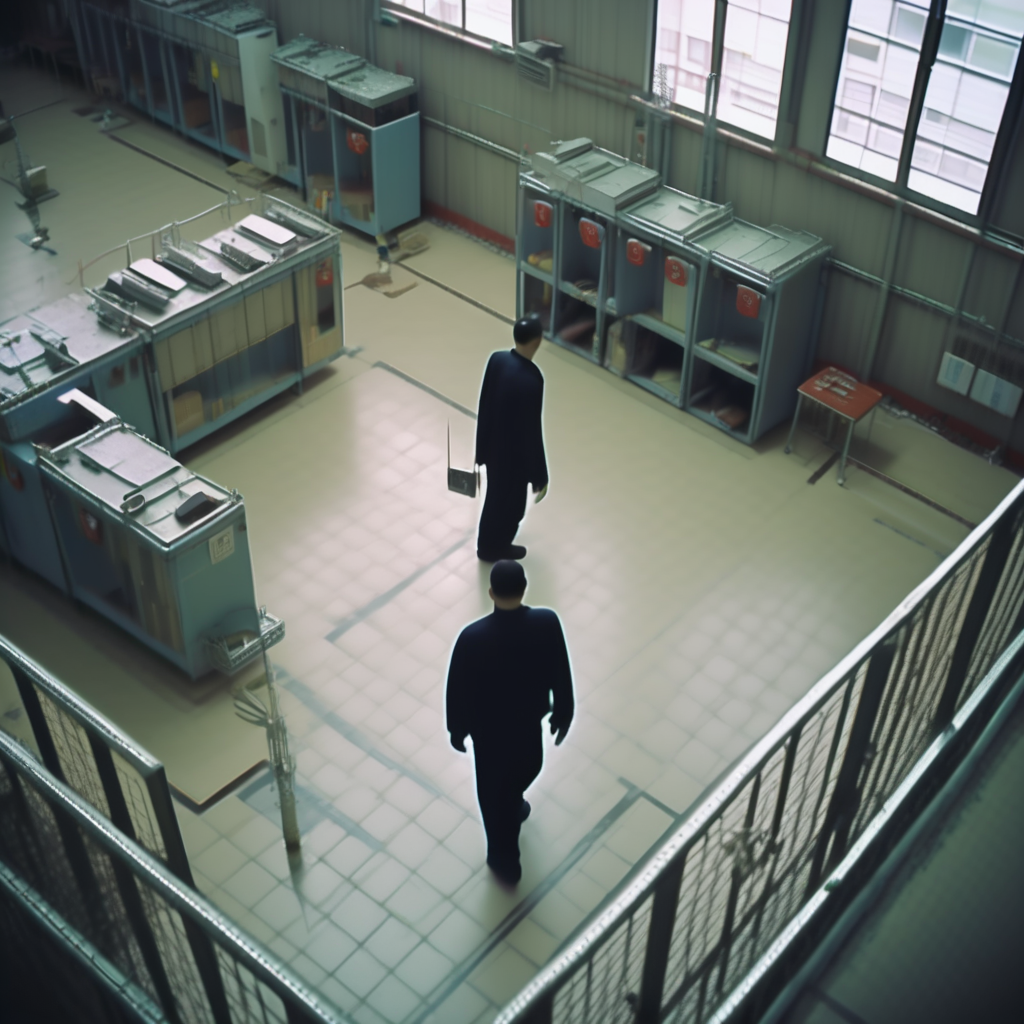

In [4]:
prompt=[
"(CCTV Footage)1.5 of A man wearing a dark jumpsuit suit walking down the halls of a factory, (high-angle shot)2",
                                                   ]
conditioning, pooled = compel(prompt)

# generate image
generator = [torch.Generator().manual_seed(49) for _ in range(len(prompt))]
images = pipeline(prompt_embeds=conditioning, pooled_prompt_embeds=pooled, generator=generator, num_inference_steps=50).images
make_image_grid(images, rows=1, cols=1)


In [ ]:
prompt=[
"(CCTV Footage)2 of A man wearing a dark jumpsuit suit walking down the halls of a factory, (high-angle shot)2",
                                                   ]
conditioning, pooled = compel(prompt)

# generate image
generator = [torch.Generator().manual_seed(23) for _ in range(len(prompt))]
images = pipeline(prompt_embeds=conditioning, pooled_prompt_embeds=pooled, generator=generator, num_inference_steps=50).images
make_image_grid(images, rows=1, cols=1)


  0%|          | 0/50 [00:00<?, ?it/s]

# Image to Image model

In [9]:
pip install Pillow


Note: you may need to restart the kernel to use updated packages.


In [17]:
from PIL import Image

image_path = './a16.jpg'
image_org = Image.open(image_path)

# To display the image (if working within a Jupyter notebook or similar environment)
# image.show()

In [18]:
init_image=images[0]
init_image

  0%|          | 0/50 [00:00<?, ?it/s]

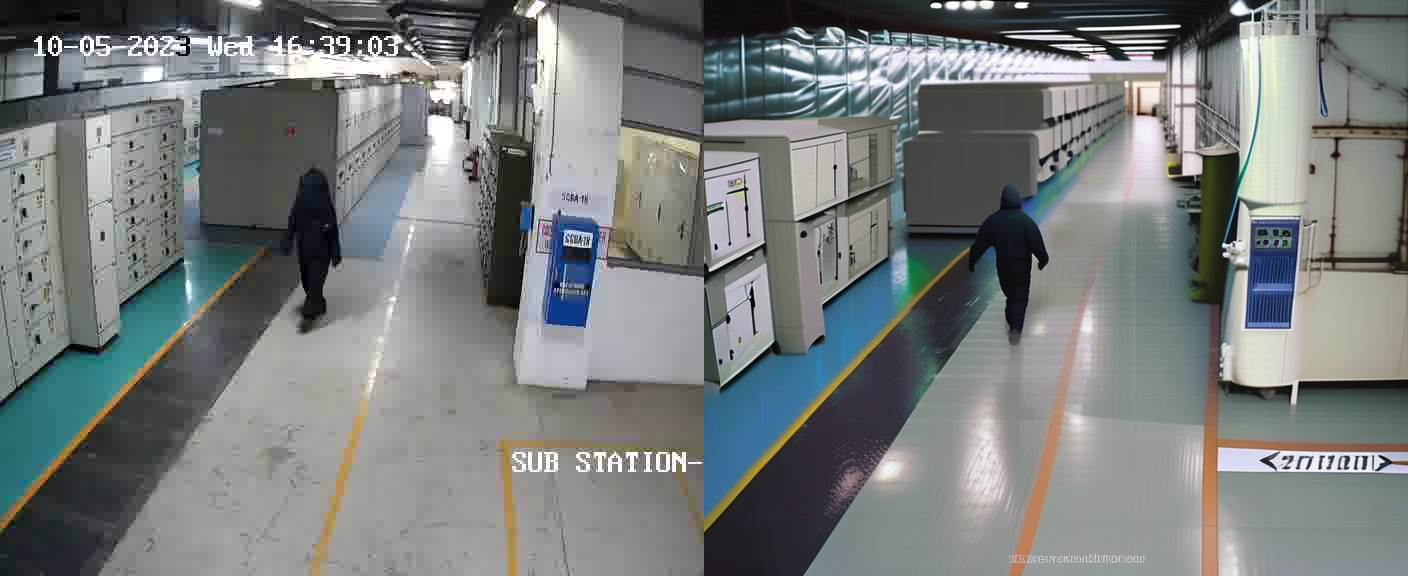

In [28]:
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import load_image, make_image_grid

# use from_pipe to avoid consuming additional memory when loading a checkpoint
pipeline_img2img = AutoPipelineForImage2Image.from_pipe(pipeline).to("cuda")

prompt = "low resolution cctv footage of a man in a dark jumpsuit walking down the hallway of a factory, muted colors,photorealistic"
image = pipeline_img2img(prompt, image=init_image, strength=0.5, guidance_scale=8,num_inference_steps=100).images[0]
make_image_grid([init_image, image], rows=1, cols=2)

  0%|          | 0/10 [00:00<?, ?it/s]

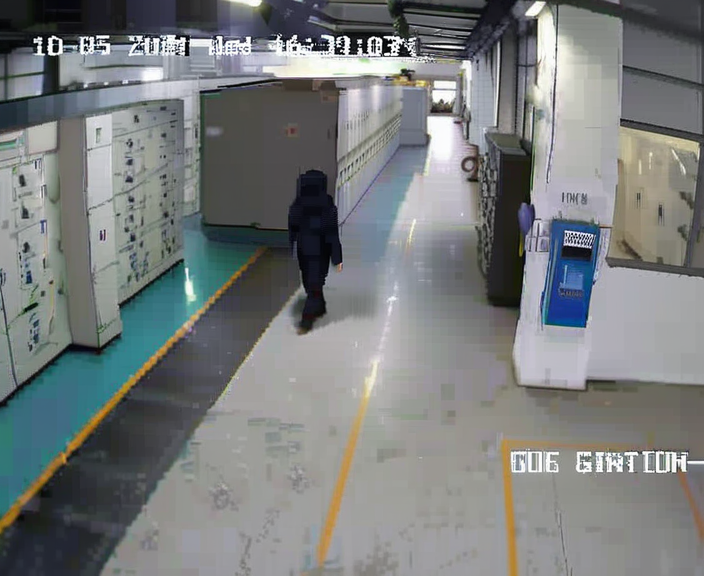

  0%|          | 0/20 [00:00<?, ?it/s]

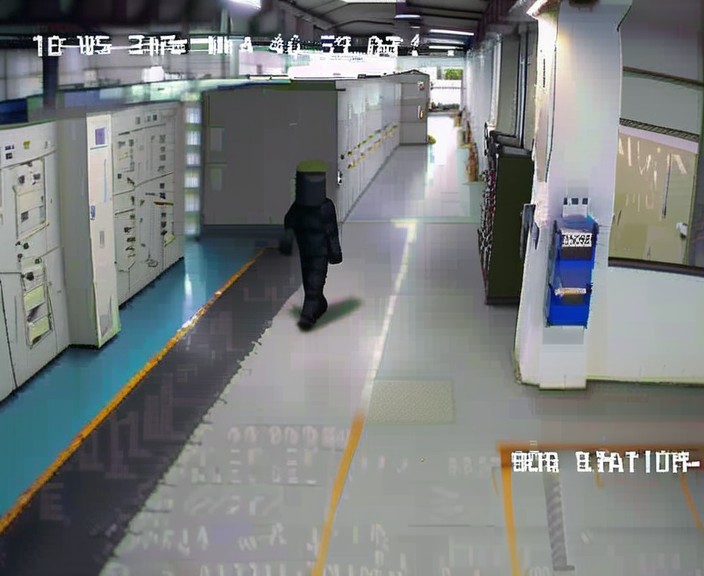

  0%|          | 0/40 [00:00<?, ?it/s]

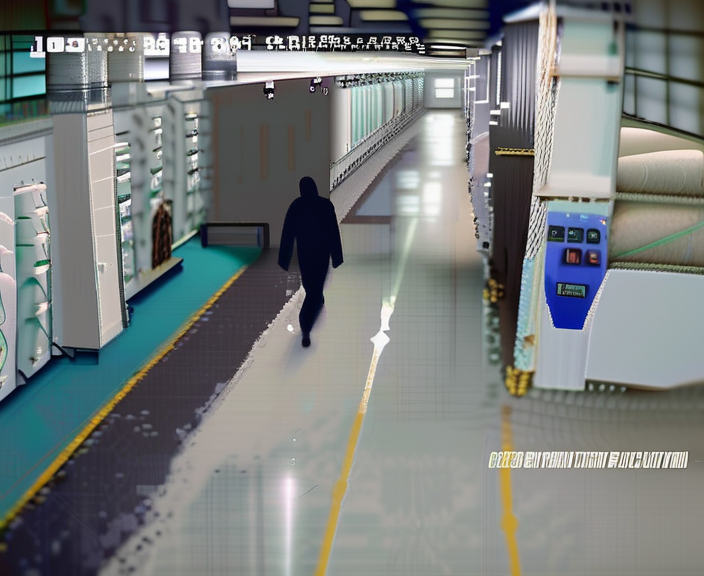

  0%|          | 0/50 [00:00<?, ?it/s]

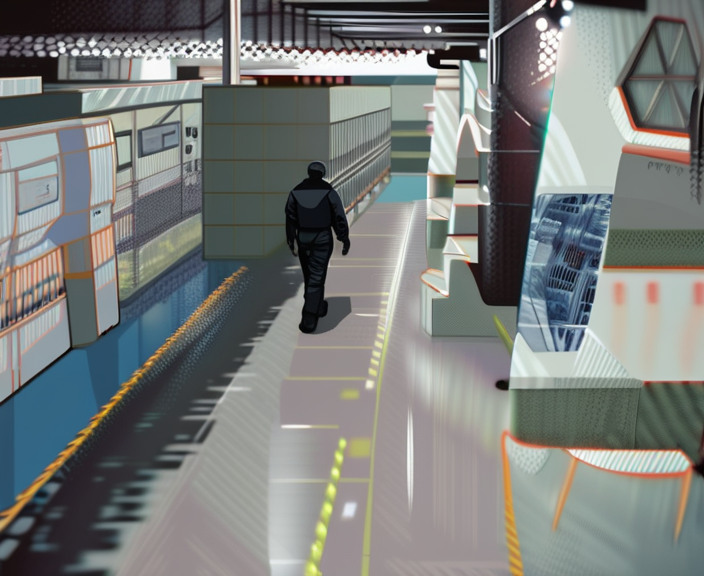

  0%|          | 0/60 [00:00<?, ?it/s]

In [ ]:
strength_list=[0.1,0.2,0.4,0.5,0.6,0.8]
for strength in strength_list:
    image = pipeline_img2img(prompt, image=init_image, strength=strength, guidance_scale=8,num_inference_steps=100).images[0]
    display(image)


# Saving Images

In [ ]:
import os
os.makedirs("task2",exist_ok=True)

In [ ]:
def save_images(images,index):
    from PIL import Image
    pil_image = images[0]
    # the PIL image to a file
    pil_image.save(f"task2/generated_image_{index+1}.png")

In [ ]:
# Assuming compel, pipeline, and other necessary imports and functions are defined
from IPython.display import display

# Generate and save 50 images
for i in range(2):
    generator = [torch.Generator().manual_seed(i + 23)]  # Update seed for each image
    conditioning, pooled = compel(prompt)
    images = pipeline(prompt_embeds=conditioning, pooled_prompt_embeds=pooled, generator=generator, num_inference_steps=10).images
    
    # Assuming `images` is a batch with a single image
    save_images(images, i)  # Save each image with a unique index
    display(images[0])
